In [23]:
import warnings
warnings.simplefilter("ignore")

import os
os.chdir('/content/drive/MyDrive/interview-nba5years')
os.listdir('.')

['resources', 'mod_selec.ipynb', 'eda.ipynb']

# Import

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

import numpy as np

from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Global variables & Utils

In [25]:
# Variables
pathdata = "./resources/nba_logreg.csv"

# Load data

In [26]:
data = pd.read_csv(pathdata)

print("- columns :", list(data.columns))
print("- nb_columns :", len(list(data.columns)))
print("- nb_features :", len(list(data.columns)[1:-1]))
print("- nb_rows :", data.shape[0])

features = list(data.columns)[1:-1]
target = list(data.columns)[-1]

- columns : ['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']
- nb_columns : 21
- nb_features : 19
- nb_rows : 1340


# Check NaN & Duplicated row

In [27]:
# NaN ?
print(data.isnull().any())

Name           False
GP             False
MIN            False
PTS            False
FGM            False
FGA            False
FG%            False
3P Made        False
3PA            False
3P%             True
FTM            False
FTA            False
FT%            False
OREB           False
DREB           False
REB            False
AST            False
STL            False
BLK            False
TOV            False
TARGET_5Yrs    False
dtype: bool


In [28]:
# Duplicated ?
print('- Duplicated row :', data.shape[0] - data.drop_duplicates().shape[0], '/', data.shape[0], '->',
      100 - round(100*data.drop_duplicates().shape[0] / data.shape[0]), '%')

- Duplicated row : 12 / 1340 -> 1 %


#### [COMMENT]
- CCL : Take into account the NaN on 3P%
- CCL2 : Remove duplicated rows

In [29]:
data = data.drop_duplicates()

# Mislabeled

In [30]:
# Mislabeled ?
idx_mislabeled = []
for name, df in data.groupby(list(data.columns[:-1])):
    if df.shape[0] > 1:
        #print(df) #If you want to see the mislabeled
        idx_mislabeled.extend(list(df.index))
        
print('- Mislabeled rows :', len(idx_mislabeled), '/', data.shape[0], '->',
      round(100*len(idx_mislabeled) / data.shape[0]) ,'%')

- Mislabeled rows : 40 / 1328 -> 3 %


#### [COMMENT]

- The number mislabeled rows is pretty low
- We will not try to correct them by hand to avoid mistakes in our side
- CCL : Remove Mislabeled

In [31]:
data = data.drop(idx_mislabeled)
data.reset_index(inplace=True, drop=True)

# Target exploration
Objective : Understand the target distribution

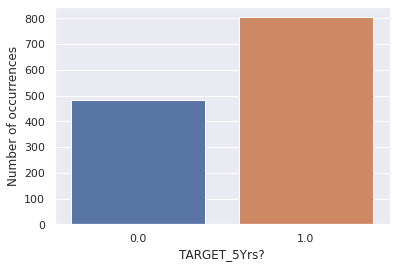

In [32]:
### Target variable exploration
sns.countplot(data['TARGET_5Yrs']);
plt.xlabel('TARGET_5Yrs?');
plt.ylabel('Number of occurrences');
plt.show()

#### [COMMENT]
- Unbalanced dataset
- ⚠ Business view we do not want to lose money by investing carelessly -> Predict correctly the label '1' is much more important than succeeding to predict the label '1' or '0'
- CCL : Need to use the Precision score
- RQ : Keep in mind that predicting the label 0 will may be difficult for the model

# Features exploration
Objective : Understand the features distribution according to the target label

- GP : games played
- MIN : minute is a unit of time in a basketball game
- PTS : Points in basketball are used to keep track of the score in a game
- FGM, FGA, FG% : field goals made, attempted and percentage
- 3P Made, 3PA, 3P% : three-point field goals made, attempted
- FTM, FTA, FT% : free throws made, attempted and percentage
- OREB, DREB, REB : offensive rebounds, defensive rebounds, rebounds
- AST : assists (attributed to a player who passes the ball to a teammate in a way that leads to a score by field goal)
- STL : steals (a steal occurs when a defensive player legally causes a turnover by his positive, aggressive action(s))
- BLK : blocks (a block or blocked shot occurs when a defensive player legally deflects a field goal attempt)
- TOV : turnovers (occurs when a team loses possession of the ball to the opposing team before a player takes a shot at their
team's basket)

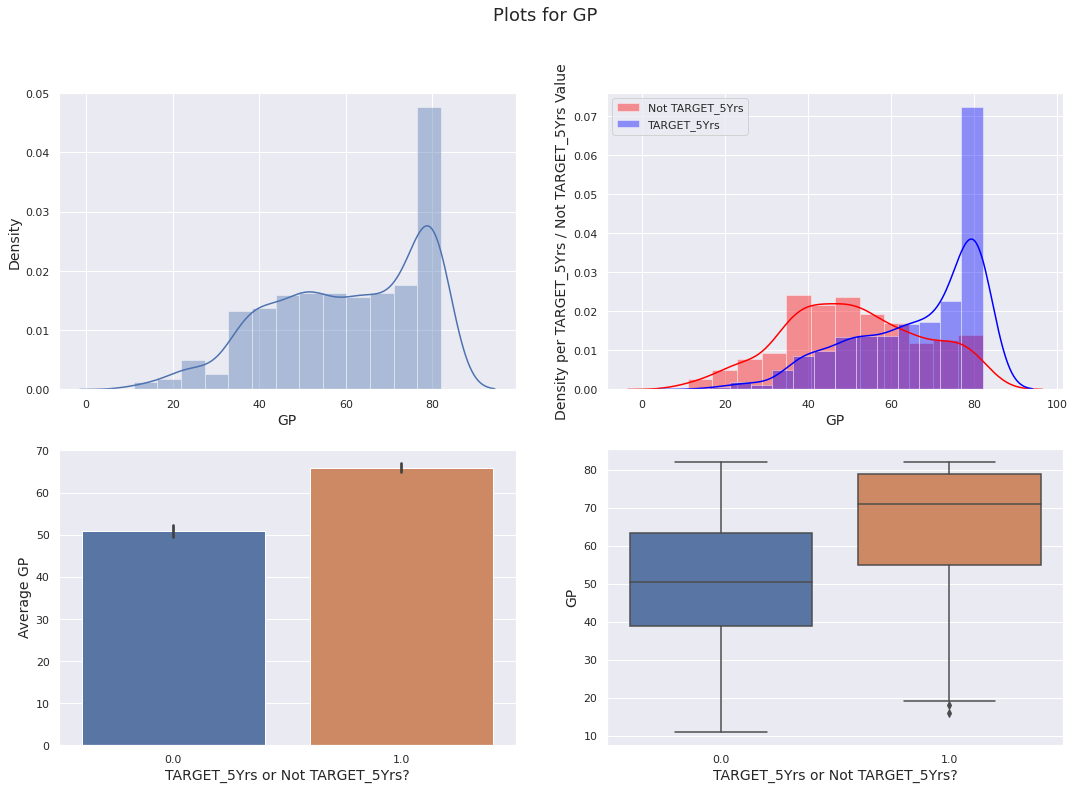

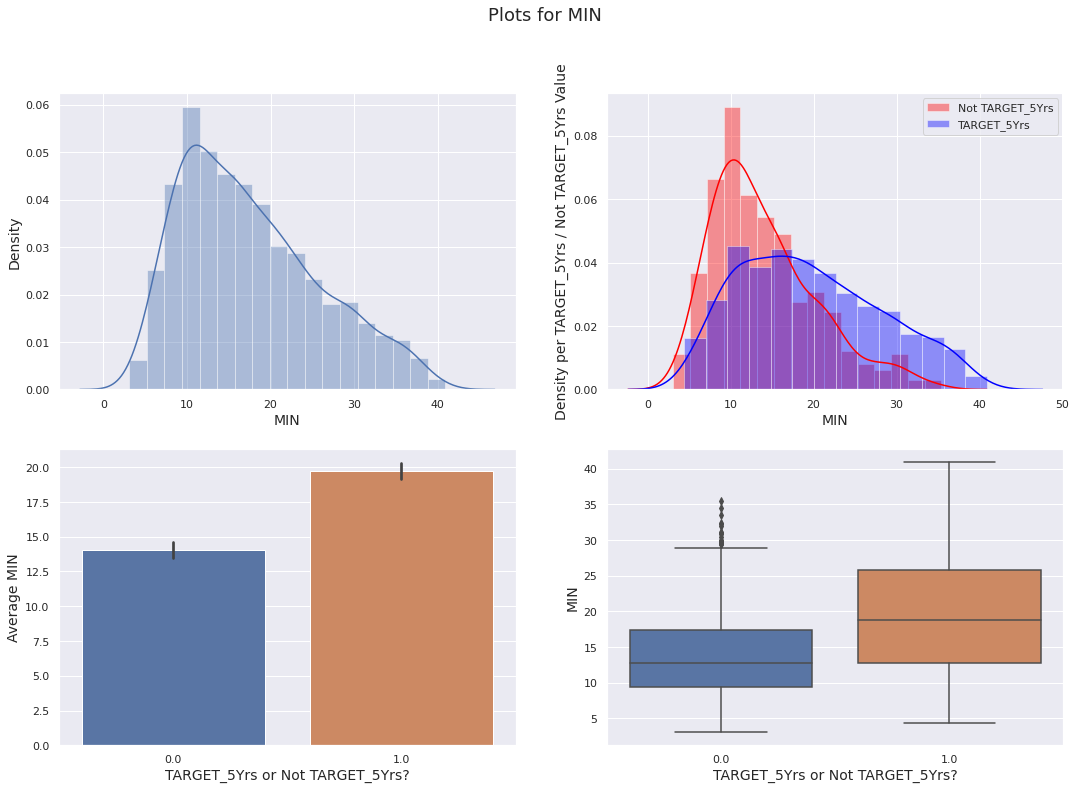

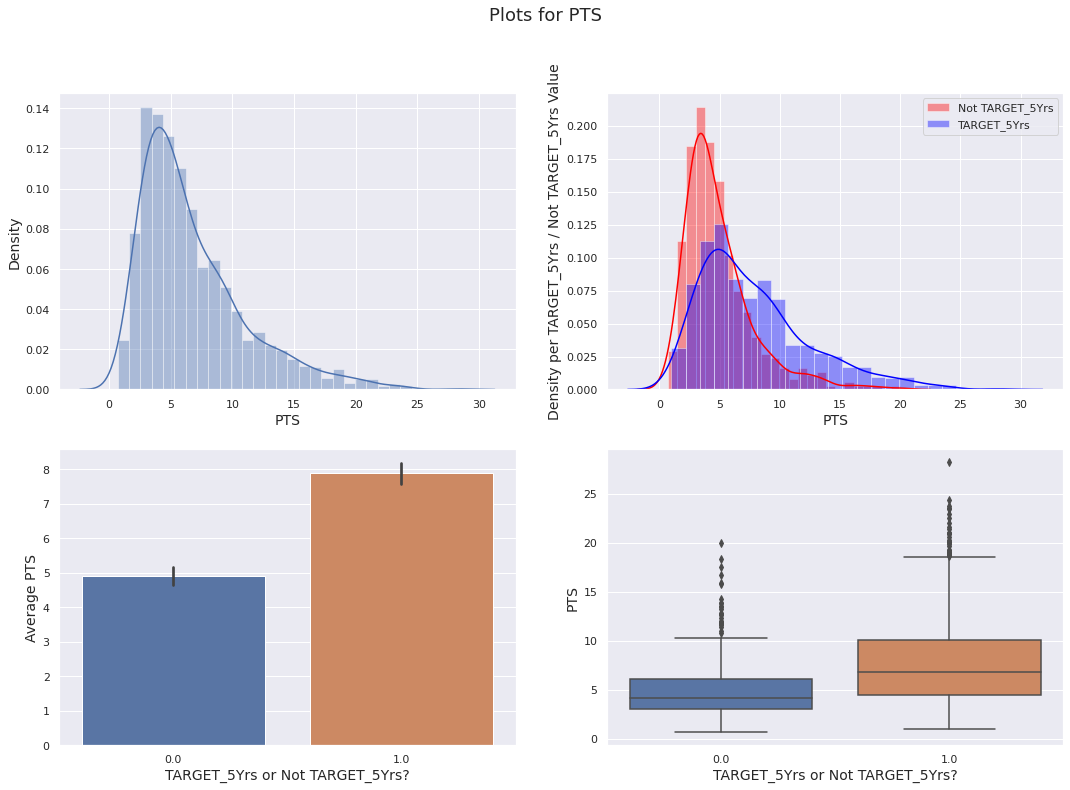

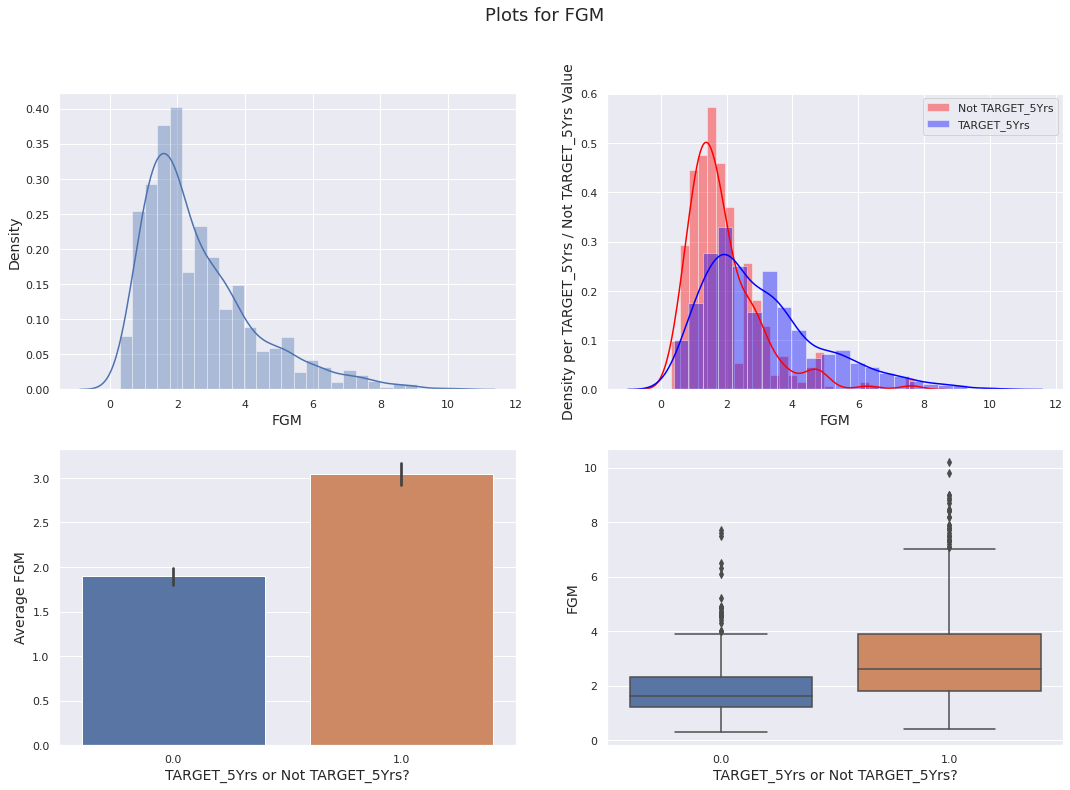

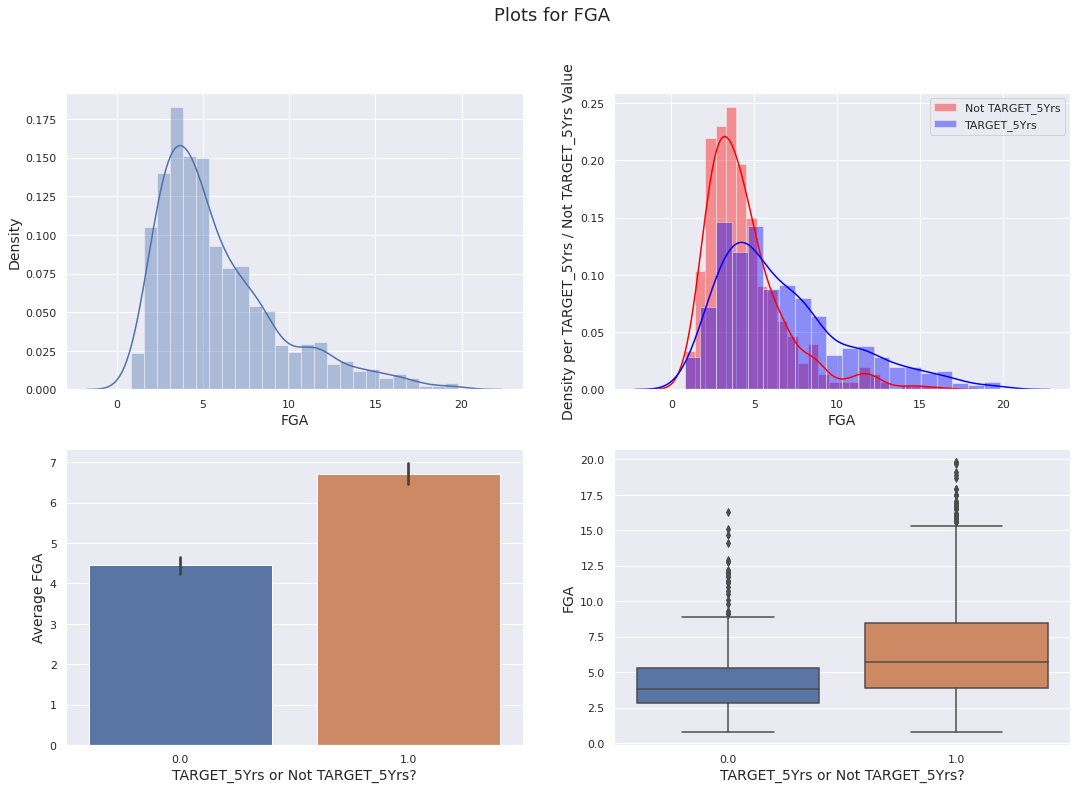

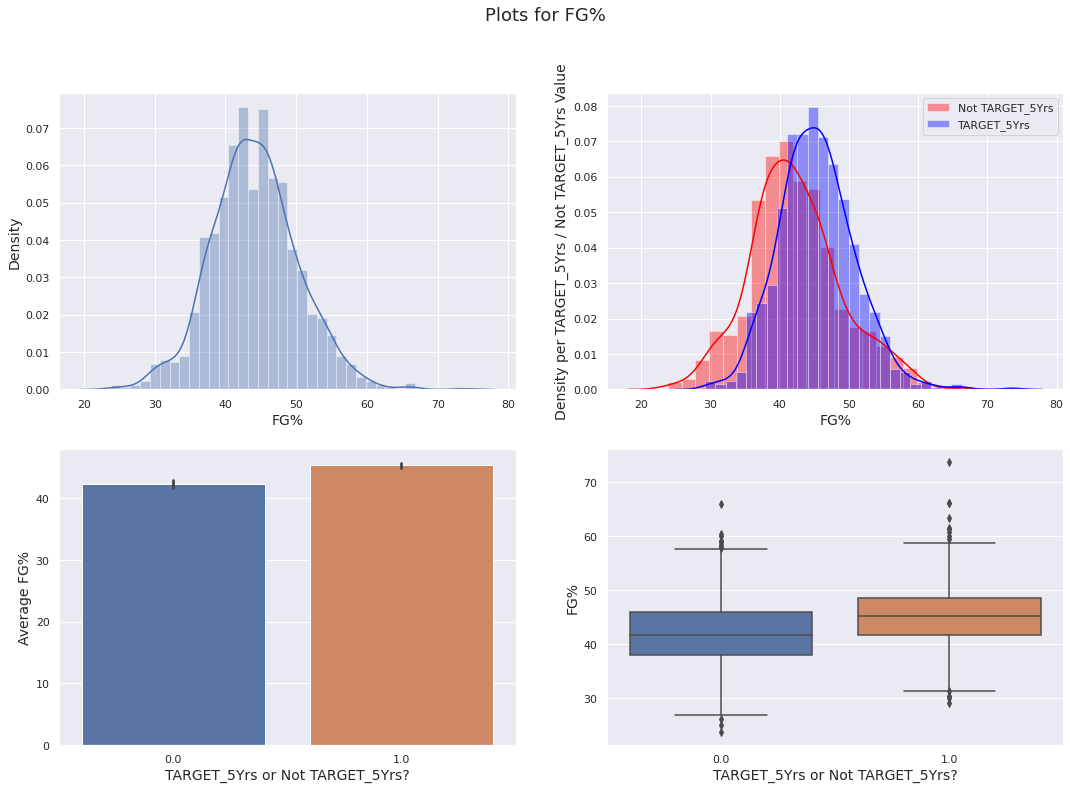

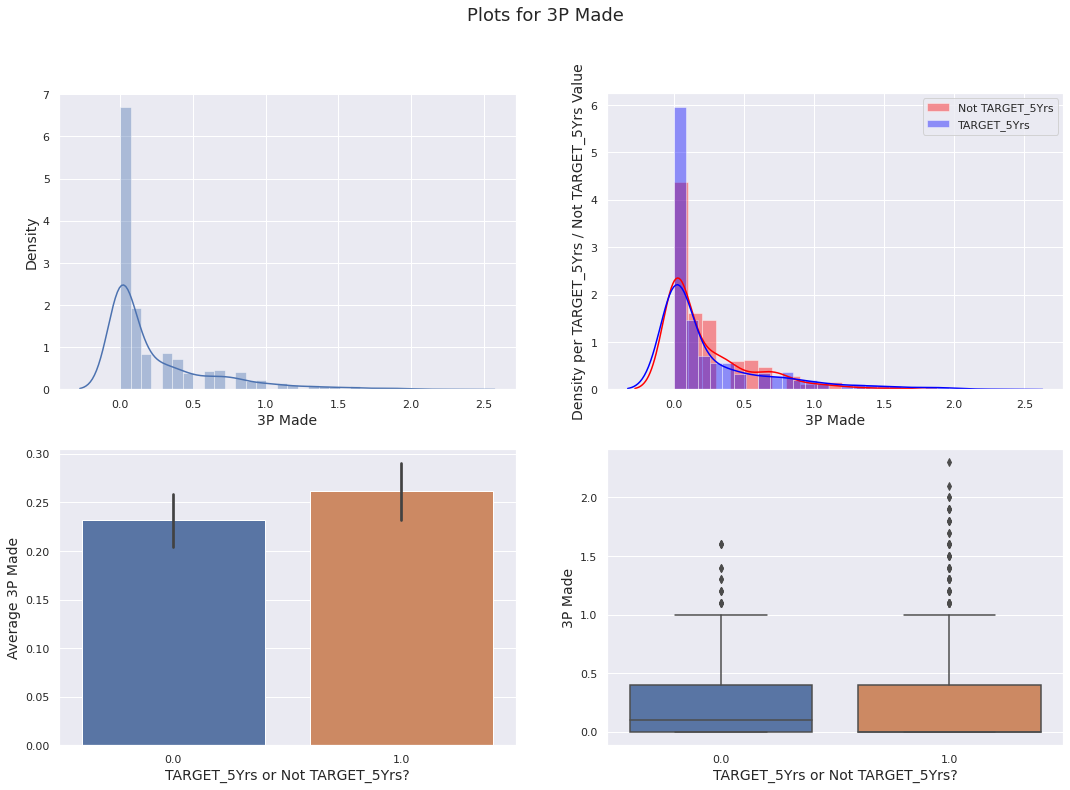

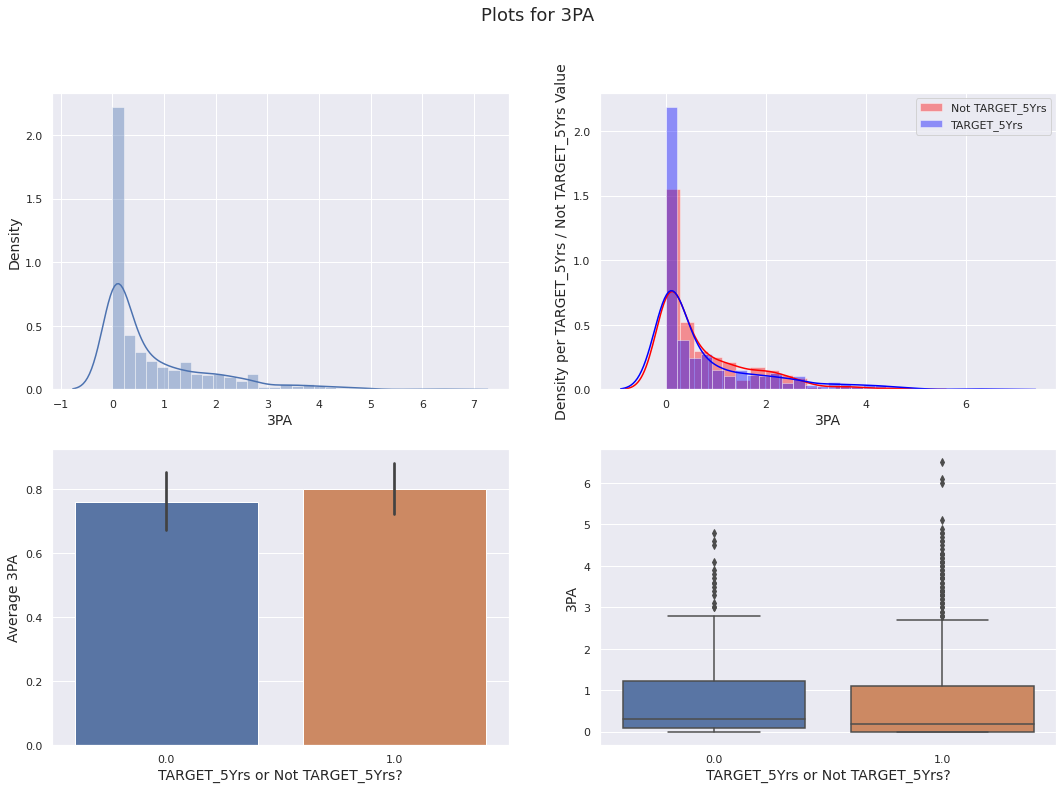

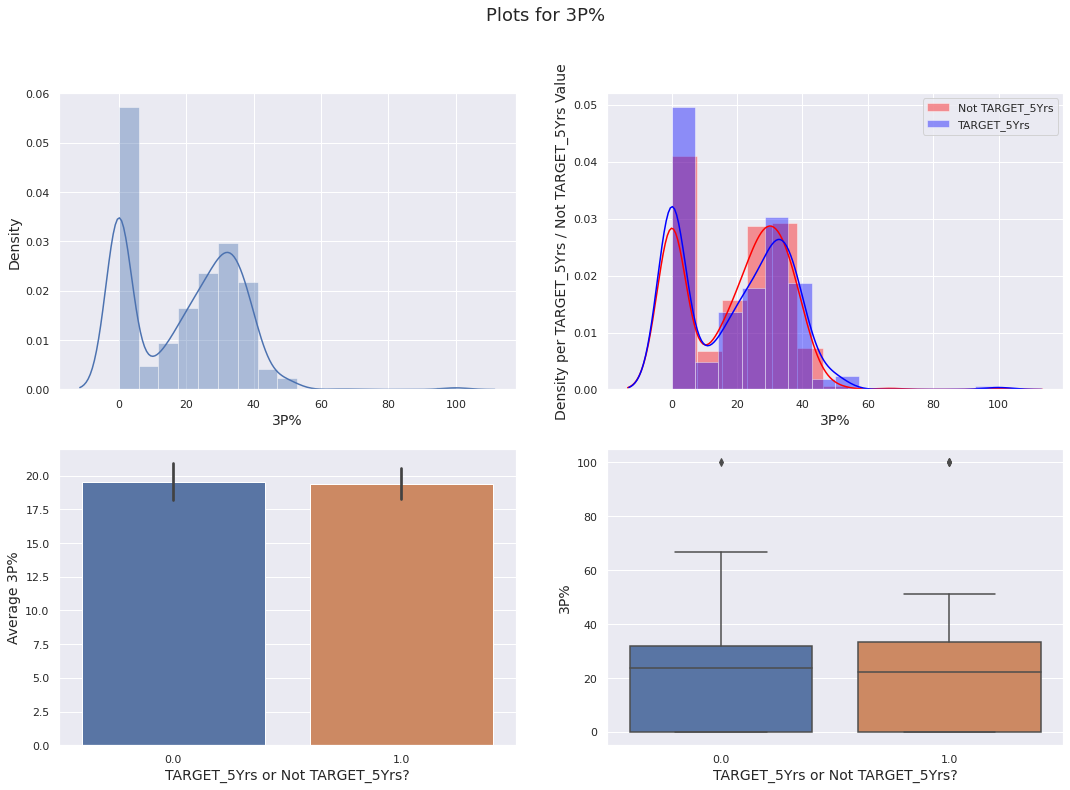

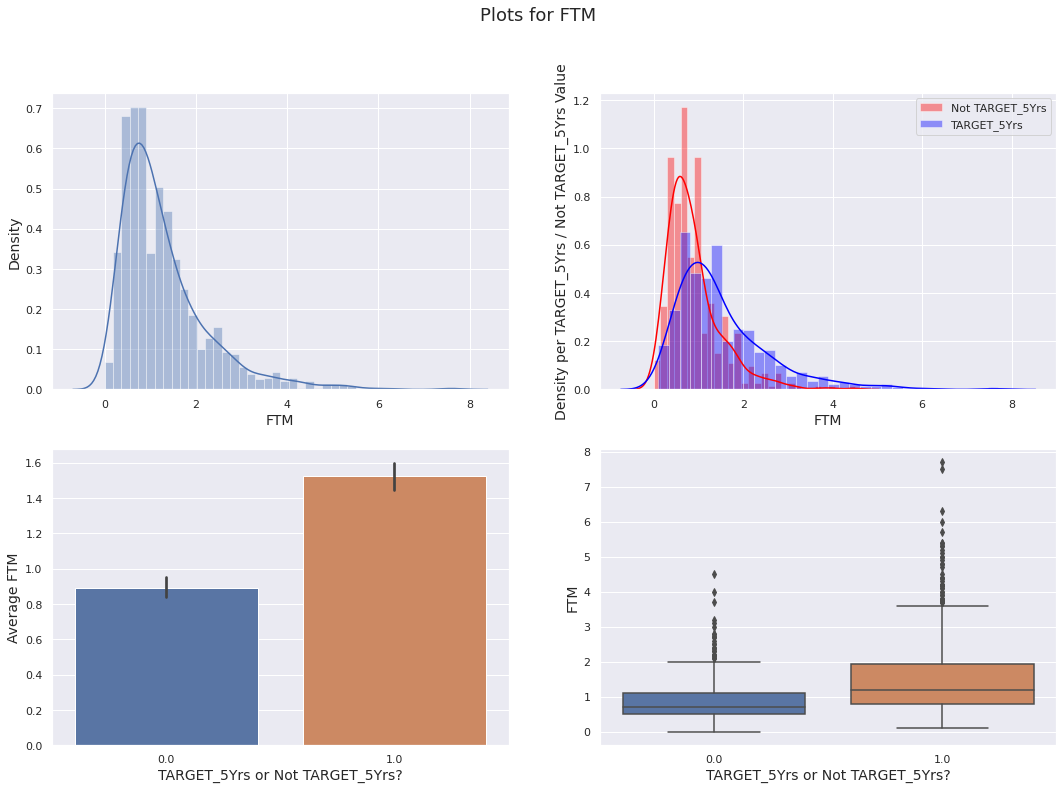

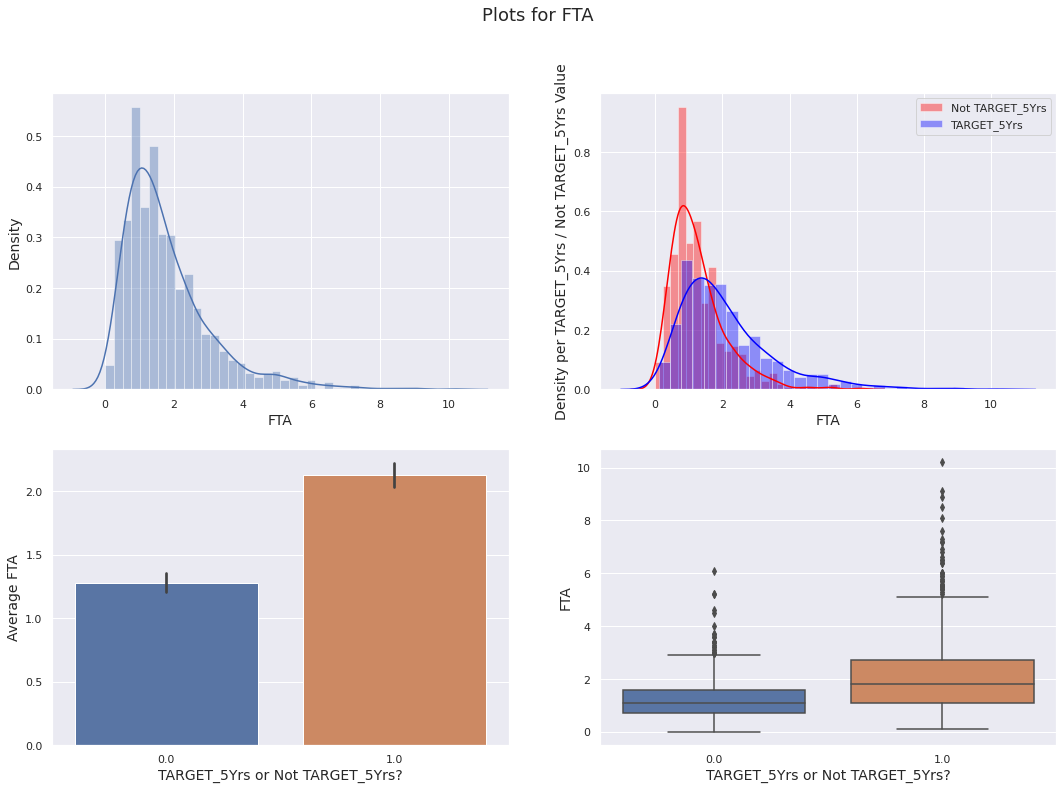

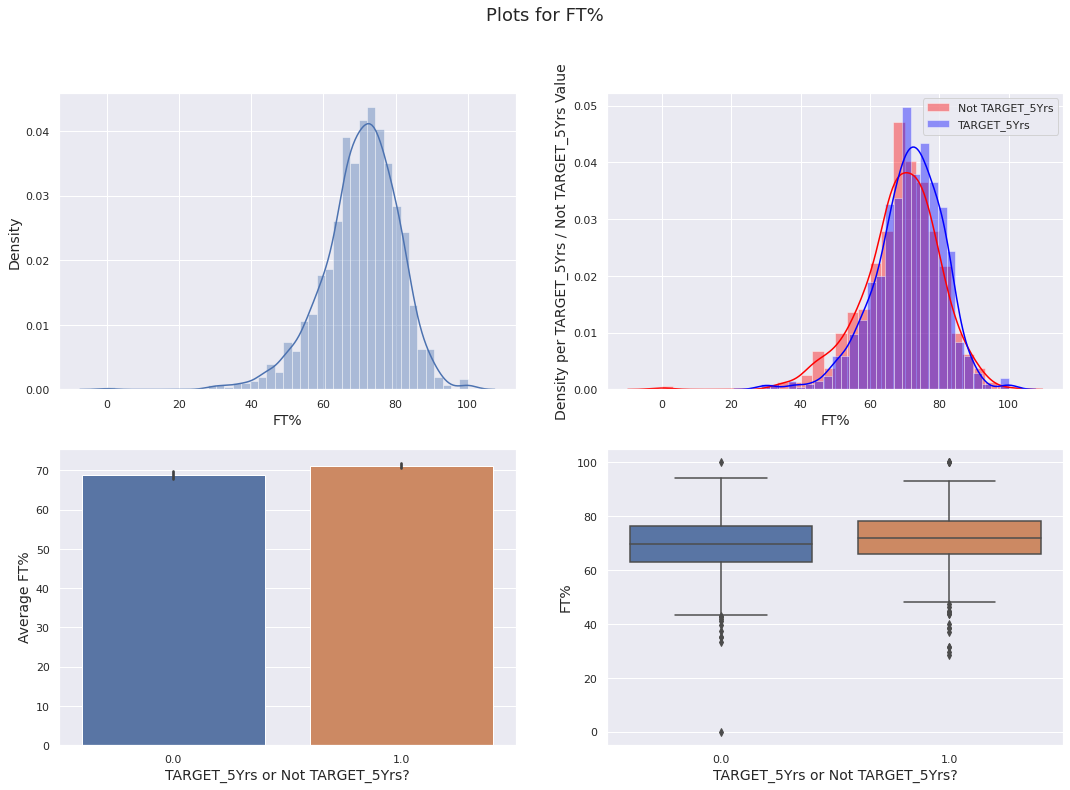

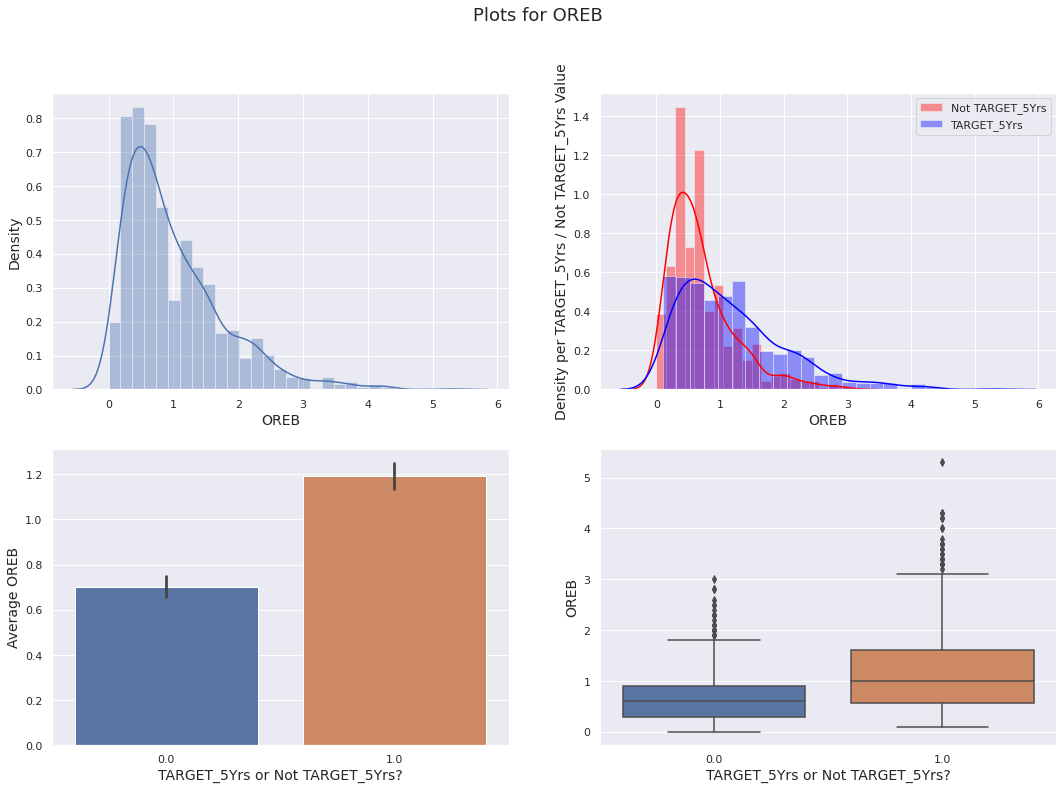

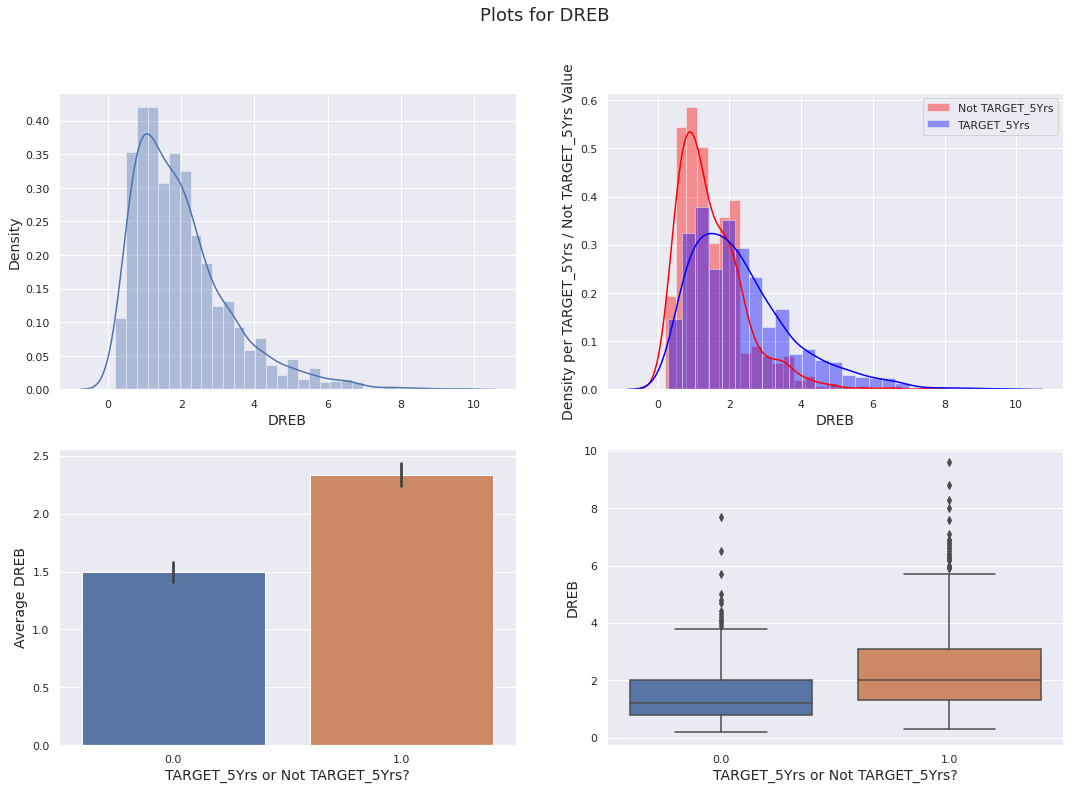

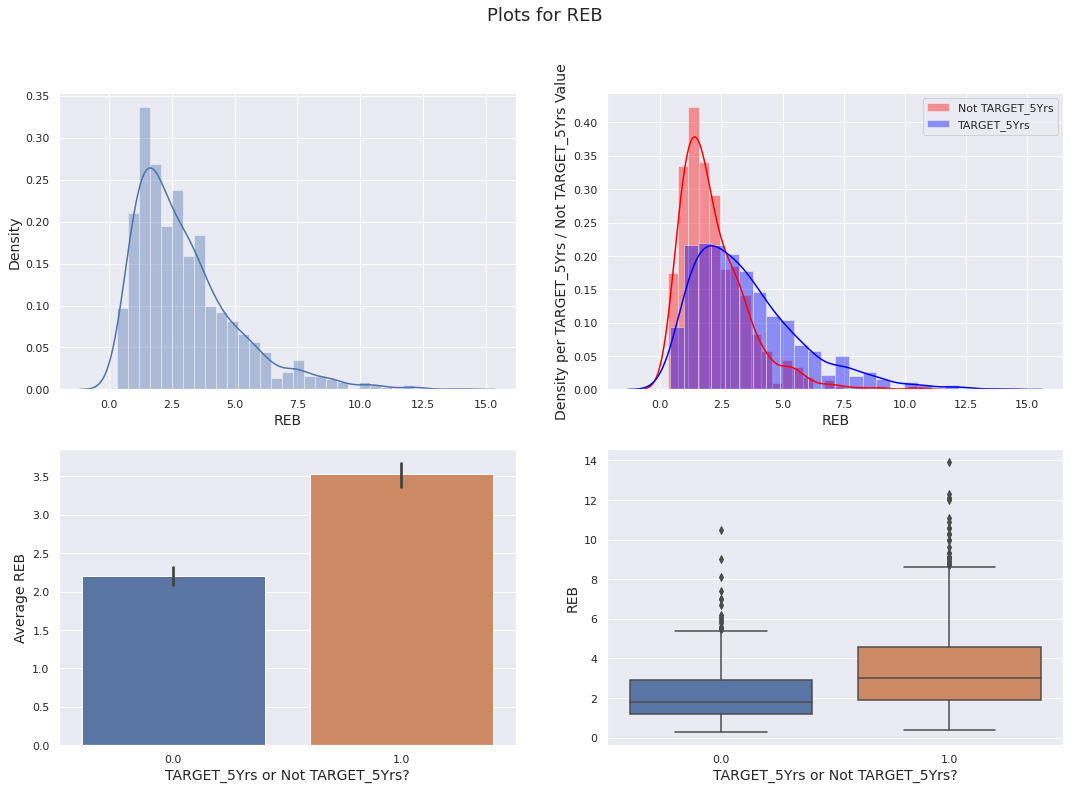

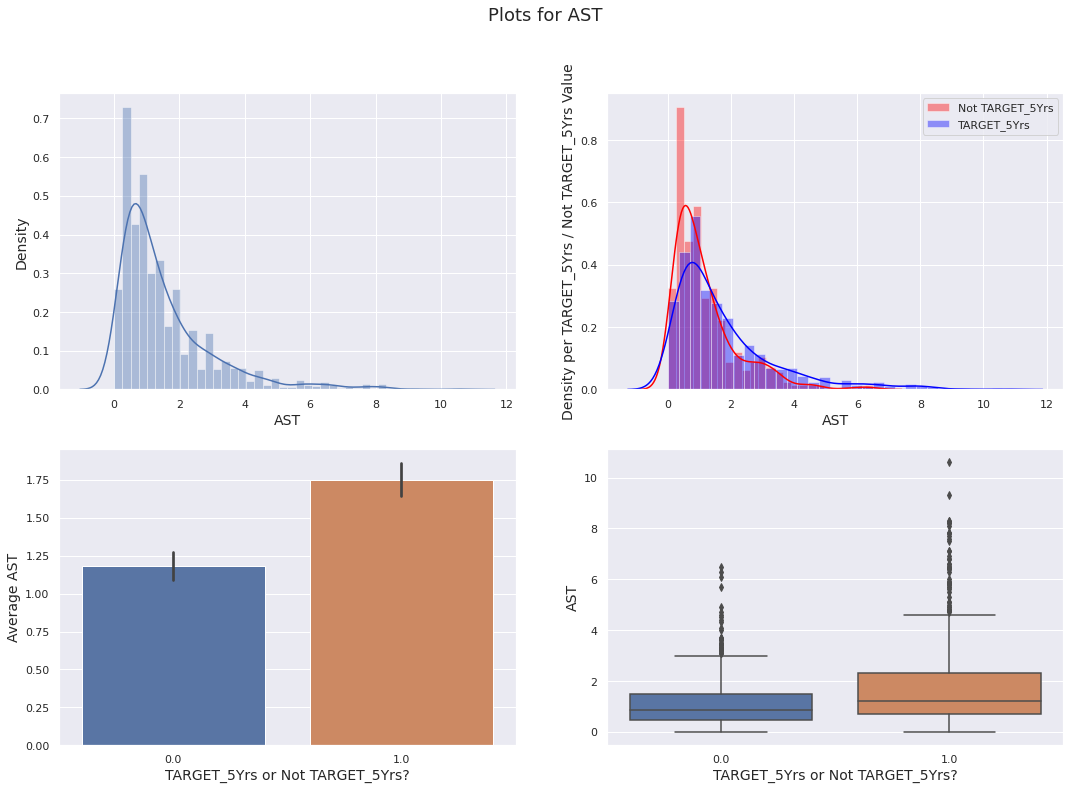

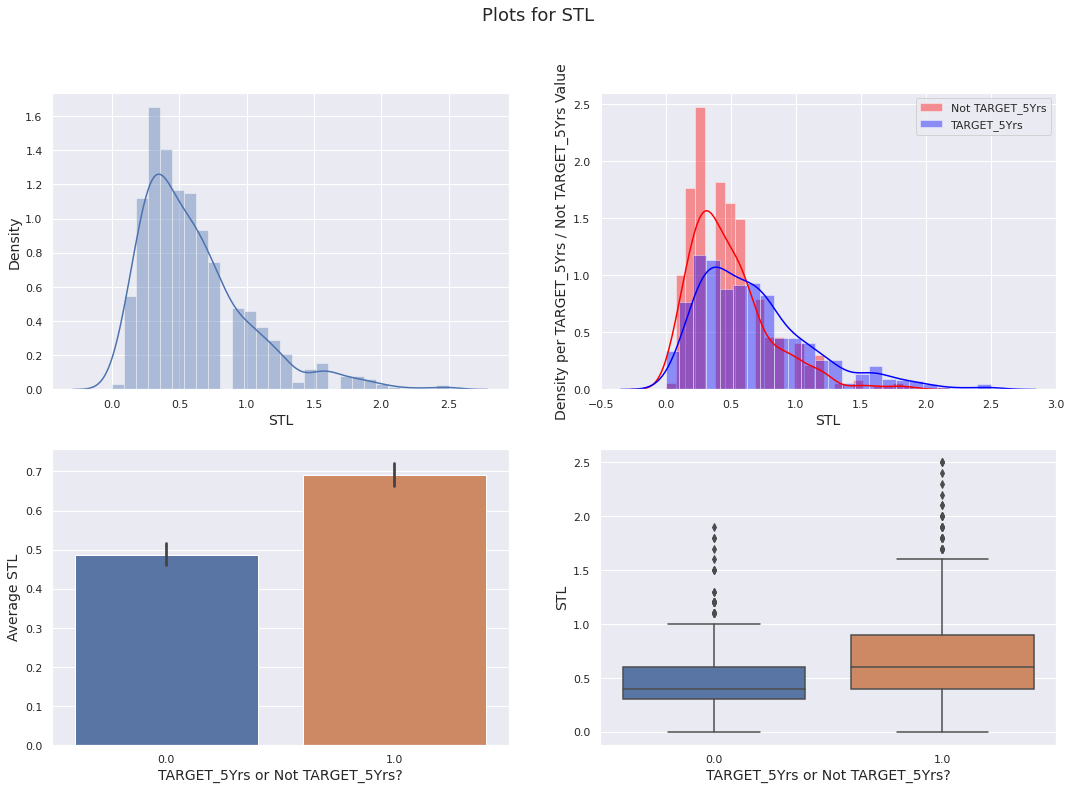

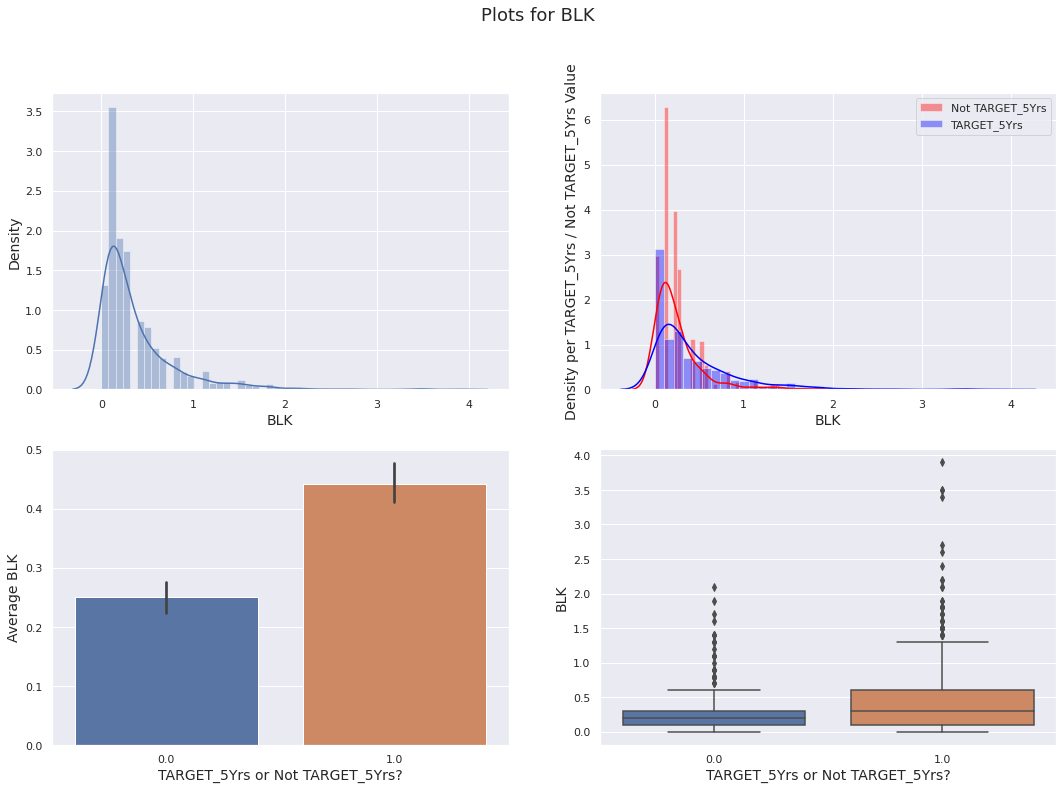

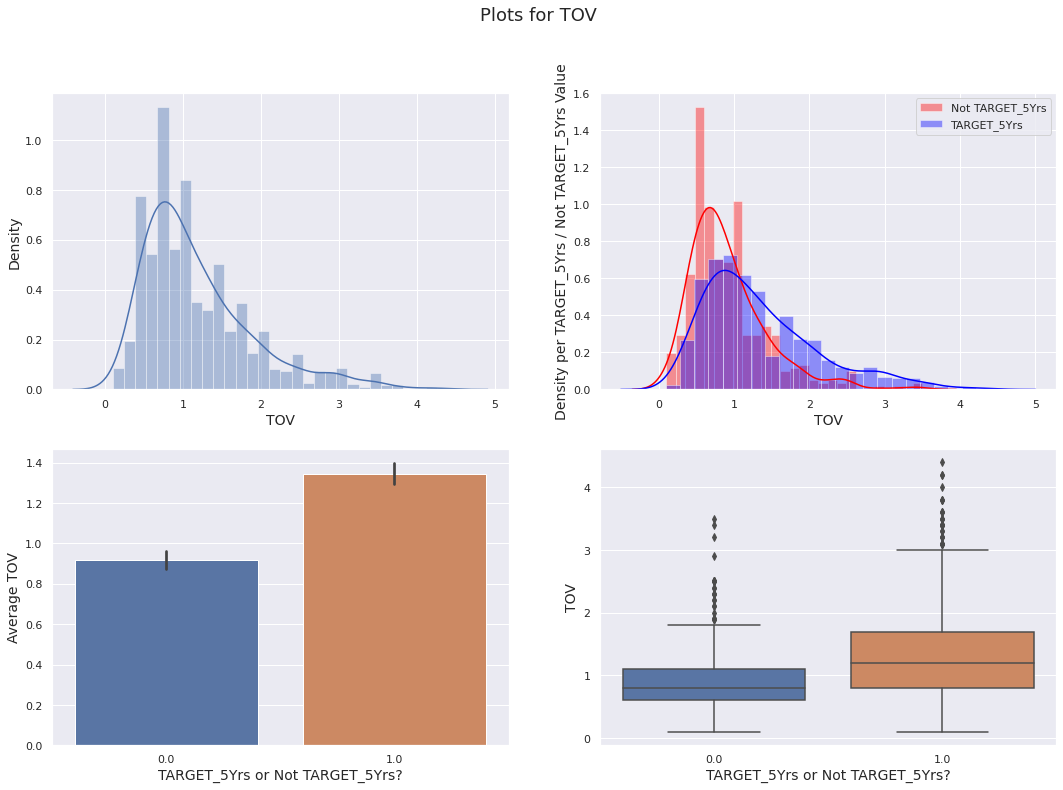

In [33]:
### Plotting Numeric Features
# Looping through and Plotting Numeric features
for column in features:    
    # Figure initiation
    fig = plt.figure(figsize=(18,12))
    
    ### Distribution plot
    sns.distplot(data[column].dropna(), ax=plt.subplot(221));
    # X-axis Label
    plt.xlabel(column, fontsize=14);
    # Y-axis Label
    plt.ylabel('Density', fontsize=14);
    # Adding Super Title (One for a whole figure)
    plt.suptitle('Plots for '+ column, fontsize=18);
    
    ### Distribution per Selected / Not Selected Value
    # Not Selected hist
    sns.distplot(data.loc[data[target]==0, column].dropna(),
                 color='red', label='Not TARGET_5Yrs', ax=plt.subplot(222));
    # Selected hist
    sns.distplot(data.loc[data[target]==1, column].dropna(),
                 color='blue', label='TARGET_5Yrs', ax=plt.subplot(222));
    # Adding Legend
    plt.legend(loc='best')
    # X-axis Label
    plt.xlabel(column, fontsize=14);
    # Y-axis Label
    plt.ylabel('Density per TARGET_5Yrs / Not TARGET_5Yrs Value', fontsize=14);
    
    ### Average Column value per Selected / Not Selected Value
    sns.barplot(x=target, y=column, data=data, ax=plt.subplot(223));
    # X-axis Label
    plt.xlabel('TARGET_5Yrs or Not TARGET_5Yrs?', fontsize=14);
    # Y-axis Label
    plt.ylabel('Average ' + column, fontsize=14);
    
    ### Boxplot of Column per Selected / Not Selected Value
    sns.boxplot(x=target, y=column, data=data, ax=plt.subplot(224));
    # X-axis Label
    plt.xlabel('TARGET_5Yrs or Not TARGET_5Yrs?', fontsize=14);
    # Y-axis Label
    plt.ylabel(column, fontsize=14);
    # Printing Chart
    plt.show()

#### [COMMENT]

Visibly not interesting features because cannot be use to differenciate labels
- 3P Made
- 3PA
- 3P%
- FT%
- CCL : Do not use them in your models

# Features selection
Objective : Remove non useful features

Methods used here :
- Pearson's correlation
- PCA
- ANOVA

### Pearson's correlation

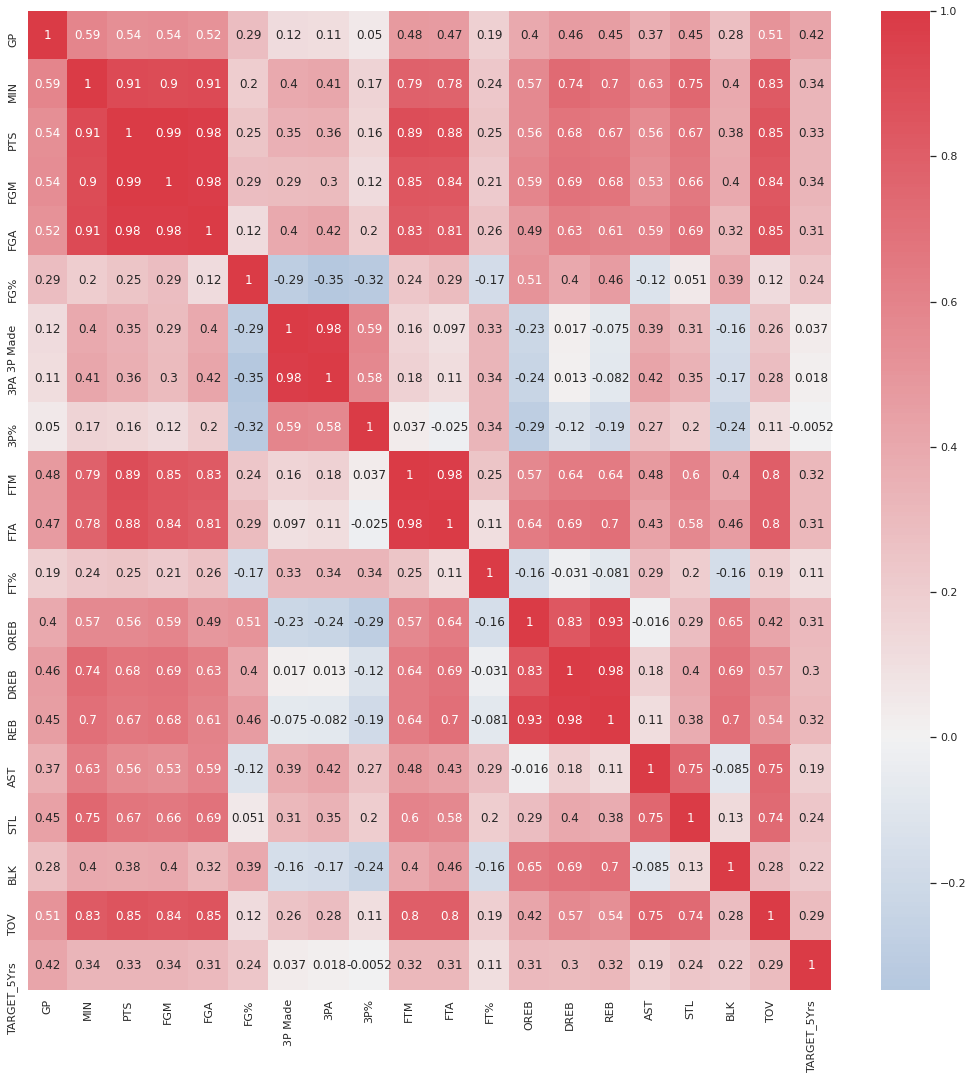

In [34]:
### Corralation matrix heatmap
# Getting correlation matrix
cor_matrix = data[features + [target]].corr()
# Plotting heatmap
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

#### [Comment]
Most correlated (>0.3) features to the TARGET_5Yrs are :
- GP > MIN > PTS > FGM
- Confirmation 3P Made, 3PA, 3P% and FT% are not useful
- CCL : Remove them

#### [Comment]
Some features are correlated (~0.9) between themselve (coherent) :
- MIN, PTS, FGM, FGA
- FTM, FTA
- DREB, REB
- 3P Made, 3PA
- CCL : Try using PCA to reduce the dimension of the linear related features (need a vizu first)

In [35]:
features_selected = features.copy()
features_selected.remove('3P Made')
features_selected.remove('3PA')
features_selected.remove('3P%') # The only column containing NaN removed
features_selected.remove('FT%')

X = data[features_selected]
Y = data[target]

# PCA

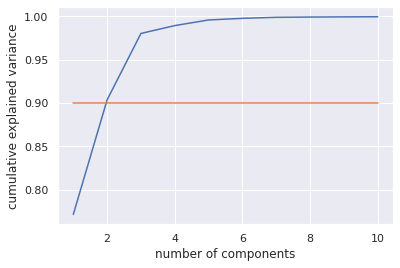

In [36]:
n_max = 10

pca = PCA(n_components=n_max)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents[:,:2], columns=['PC1','PC2']) #PC = Principal component 

# Viz explained variance
plt.plot(list(range(1,n_max+1)), np.cumsum(pca.explained_variance_ratio_))
plt.plot(list(range(1,n_max+1)), [0.90]*n_max)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### [COMMENT]

- 2 components are enough to represent 90% of the information

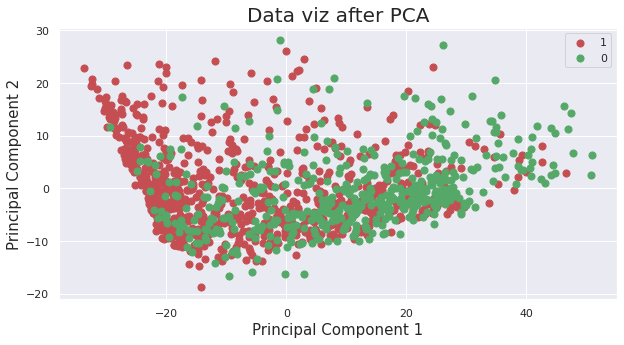

In [37]:
# Visualize the Data as 2D.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Data viz after PCA', fontsize = 20)

targets_cod = [1,0]

colors = ['r','g']

for target_cod, color in zip(targets_cod,colors):
    indicesToKeep = data[target] == target_cod
    ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets_cod)
plt.show()

#### [COMMENT]

- Principal Component Analysis representation are not useful to distinguish the two classes
- CCL : Kept the feature as it is and do not use PC1 & PC2 representation

### ANOVA

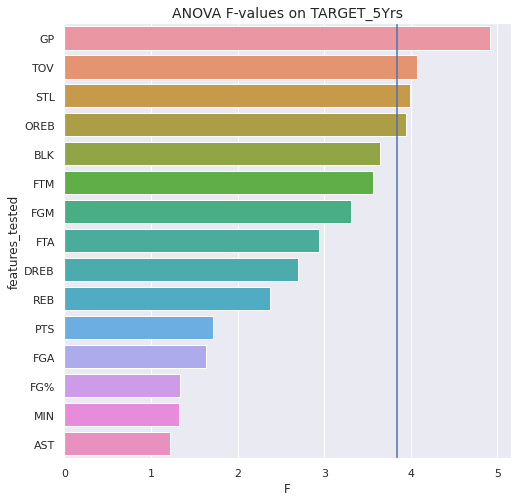

In [38]:
## Do ANOVA one-way F-test
f=[];p=[]

for col in features_selected:
    
    indat = pd.DataFrame({'TARGET_5Yrs': Y, 'cat_col': X[col]})
    model = ols('TARGET_5Yrs ~ C(cat_col)', data=indat).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    f.append(anova_table.iloc[0, 2])
    p.append(anova_table.iloc[0, 3])
    
## Data viz
anova = pd.DataFrame({'features_tested': features_selected, 'F': f, 'p':p})
anova = anova.sort_values(by=['F'], ascending=False)\
.reset_index(drop=True)

plt.figure(figsize=(8,8))
ax = sns.barplot(x=anova.F, y=anova.features_tested)
plt.axvline(x=3.8415) # with alpha = 0.05 -> F_critical = 3.8415
plt.title('ANOVA F-values on TARGET_5Yrs', fontsize=14)
plt.show()

#### [COMMENT]

Most Characteristical features by variance distinction are
- GP > TOV > STL > OREB too keep
- AST seems not very powerful to distinguish the two labels according to this test
- Pearson's correlaton also shows that fact
- CCL : Remove AST

More detail in the F-Test result
- df_between = 2 (degree of freedom)
- df_within ~ inf
- So with alpha = 0.05 -> F_critical = 3.8415

In [39]:
features_selected.remove('AST')
features_selected = ['GP', 'TOV', 'STL', 'OREB']
X = data[features_selected]
Y = data[target]

# Final decision on the features

In [40]:
print('Going to use :', features_selected)
print('To predict :', target)

Going to use : ['GP', 'TOV', 'STL', 'OREB']
To predict : TARGET_5Yrs
